In [1]:
"""

What this script does:
 - Generates synthetic financial data (mu, sigma)
 - Builds a PortfolioOptimization Quadratic Program
 - Solves using:
       (1) Classical NumPyMinimumEigensolver
       (2) SamplingVQE (TwoLocal ansatz + COBYLA)
 - Prints full probability distribution from VQE
 - Includes optional CVaR (post-processing)

Dependencies:
 - qiskit-terra
 - qiskit-aer
 - qiskit-finance
 - qiskit-optimization
 - qiskit-algorithms
"""

from qiskit.circuit.library import TwoLocal
from qiskit.result import QuasiDistribution
from qiskit_aer.primitives import Sampler
from qiskit_algorithms import NumPyMinimumEigensolver, SamplingVQE
from qiskit_algorithms.optimizers import COBYLA
from qiskit_finance.applications.optimization import PortfolioOptimization
from qiskit_finance.data_providers import RandomDataProvider
from qiskit_optimization.algorithms import MinimumEigenOptimizer

from qiskit_algorithms.utils import algorithm_globals
import numpy as np
import matplotlib.pyplot as plt
import datetime


In [2]:
# -------------------------
# PARAMETERS
# -------------------------
num_assets = 4
seed = 123
algorithm_globals.random_seed = seed

risk_factor = 0.5
budget = num_assets // 2

ansatz_reps = 2
cobyla_maxiter = 200
cvar_alpha = 0.2  # 20% best outcomes



In [4]:
#--------------------------
# 1) FINANCIAL DATA GENERATION
# -------------------------
tickers = [f"TICKER{i}" for i in range(num_assets)]

data_provider = RandomDataProvider(
    tickers=tickers,
    start=datetime.datetime(2016, 1, 1),
    end=datetime.datetime(2016, 1, 30),
    seed=seed,
)
data_provider.run()

mu = data_provider.get_period_return_mean_vector()
sigma = data_provider.get_period_return_covariance_matrix()

print("Mean returns (mu):\n", mu)
print("\nCovariance matrix (sigma):\n", sigma)


Mean returns (mu):
 [ 0.01528439 -0.00078095  0.00051792  0.00087001]

Covariance matrix (sigma):
 [[ 2.54138859e-03  7.34022167e-05  1.28600531e-04 -9.98612132e-05]
 [ 7.34022167e-05  2.58486713e-04  5.30427595e-05  4.44816208e-05]
 [ 1.28600531e-04  5.30427595e-05  7.91504681e-04 -1.23887382e-04]
 [-9.98612132e-05  4.44816208e-05 -1.23887382e-04  1.97892585e-04]]


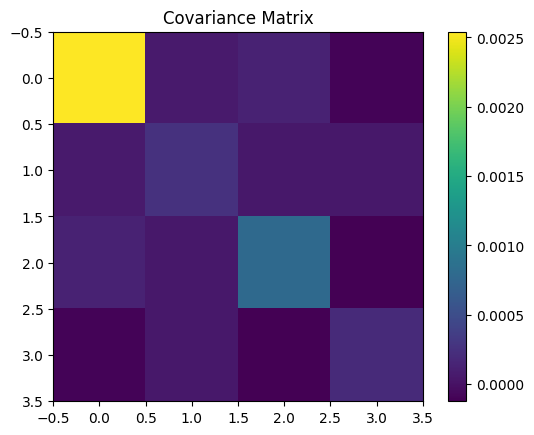

In [5]:
# optional heatmap
try:
    plt.imshow(sigma, interpolation="nearest")
    plt.title("Covariance Matrix")
    plt.colorbar()
    plt.show()
except:
    pass


In [7]:
#-------------------------
# 2) BUILD QP FOR PORTFOLIO OPTIMIZATION
# -------------------------
portfolio = PortfolioOptimization(mu, sigma, risk_factor, budget)
qp = portfolio.to_quadratic_program()

print("\nQuadratic Program:")
print(qp.prettyprint())



Quadratic Program:
Problem name: Portfolio optimization

Minimize
  0.001270694296030004*x_0^2 + 7.34022166934733e-05*x_0*x_1
  + 0.00012860053085450988*x_0*x_2 - 9.986121318021848e-05*x_0*x_3
  + 0.00012924335651113268*x_1^2 + 5.304275948260219e-05*x_1*x_2
  + 4.4481620835391664e-05*x_1*x_3 + 0.0003957523406615203*x_2^2
  - 0.00012388738164026145*x_2*x_3 + 9.89462926895246e-05*x_3^2
  - 0.015284386651719337*x_0 + 0.0007809521451492393*x_1
  - 0.0005179205467023194*x_2 - 0.0008700058372126832*x_3

Subject to
  Linear constraints (1)
    x_0 + x_1 + x_2 + x_3 == 2  'c0'

  Binary variables (4)
    x_0 x_1 x_2 x_3



In [8]:
# -------------------------
# HELPER Functions
# -------------------------
def print_result(result, portfolio_obj, title="Result"):
    print("\n" + "=" * 40)
    print(title)
    print("=" * 40)

    try:
        print("Optimal selection:", result.x)
        print("Objective value: ", result.fval)
    except:
        pass

    eigen = getattr(result.min_eigen_solver_result, "eigenstate", None)
    if eigen is None:
        print("No eigenstate found (classical solver).")
        return

    # Extract probabilities
    if isinstance(eigen, QuasiDistribution):
        probs = eigen.binary_probabilities()
    else:
        amp = eigen.to_dict()
        probs = {k: np.abs(v)**2 for k, v in amp.items()}

    probs = sorted(probs.items(), key=lambda x: x[1], reverse=True)

    print("\nBitstring probabilities:")
    print("bitstring\tvalue\t\tprob")
    print("--------------------------------------")

    for bit, p in probs[:10]:
        arr = np.array([int(i) for i in bit[::-1]])  # reversed for QP convention
        val = portfolio_obj.to_quadratic_program().objective.evaluate(arr)
        print(f"{arr}\t{val:.6f}\t{p:.6f}")


def compute_cvar(eigenstate, portfolio_obj, alpha=0.2):
    """Optional CVaR estimation from VQE sampling distribution."""
    if eigenstate is None:
        return None

    if isinstance(eigenstate, QuasiDistribution):
        probs = eigenstate.binary_probabilities()
    else:
        amp = eigenstate.to_dict()
        probs = {k: np.abs(v)**2 for k, v in amp.items()}

    dist = []
    for bit, p in probs.items():
        arr = np.array([int(i) for i in bit[::-1]])
        val = portfolio_obj.to_quadratic_program().objective.evaluate(arr)
        dist.append((bit, val, p))

    dist.sort(key=lambda x: x[1])  # sort by energy (lowest first)

    selected = []
    cumulative = 0.0
    for bit, val, p in dist:
        selected.append((bit, val, p))
        cumulative += p
        if cumulative >= alpha:
            break

    total_p = sum(x[2] for x in selected)
    cvar_val = sum(val * p for (_, val, p) in selected) / total_p

    return cvar_val, selected

In [9]:
# -------------------------
# 3) CLASSICAL BASELINE
# -------------------------
print("\nRunning classical NumPyMinimumEigensolver…")
classical_solver = NumPyMinimumEigensolver()
meo_classical = MinimumEigenOptimizer(classical_solver)
result_classical = meo_classical.solve(qp)

print_result(result_classical, portfolio, "Classical Solver")



Running classical NumPyMinimumEigensolver…

Classical Solver
Optimal selection: [1. 0. 0. 1.]
Objective value:  -0.01488461311339271

Bitstring probabilities:
bitstring	value		prob
--------------------------------------
[1 0 0 1]	-0.014885	1.000000


In [11]:
# -------------------------
# 4) SAMPLING-VQE
# -------------------------
print("\nPreparing VQE…")

try:
    sampler = Sampler()
    print("Sampler backend loaded.")

    ansatz = TwoLocal(
        num_qubits=num_assets,
        rotation_blocks="ry",
        entanglement_blocks="cz",
        reps=ansatz_reps
    )

    optimizer = COBYLA(maxiter=cobyla_maxiter)

    vqe = SamplingVQE(
        sampler=sampler,
        ansatz=ansatz,
        optimizer=optimizer
    )

    meo_vqe = MinimumEigenOptimizer(vqe)
    result_vqe = meo_vqe.solve(qp)

    print_result(result_vqe, portfolio, "Sampling VQE")

    # Optional CVaR
    ev = result_vqe.min_eigen_solver_result.eigenstate
    cvar_result = compute_cvar(ev, portfolio, alpha=cvar_alpha)
    if cvar_result:
        cvar_value, chosen = cvar_result
        print(f"\nCVaR-alpha={cvar_alpha}: {cvar_value:.6f}")
        print("States included in CVaR calculation:")
        for b, val, p in chosen:
            print(b, val, p)

except Exception as e:
    print("\nVQE failed:", e)





Preparing VQE…
Sampler backend loaded.

Sampling VQE
Optimal selection: [1. 0. 0. 1.]
Objective value:  -0.01488461311339271

Bitstring probabilities:
bitstring	value		prob
--------------------------------------
[0 1 0 1]	0.000184	0.953125
[0 1 1 1]	-0.000009	0.014648
[1 1 0 0]	-0.013030	0.011719
[1 0 0 1]	-0.014885	0.008789
[0 0 0 0]	0.000000	0.003906
[1 1 0 1]	-0.013857	0.003906
[0 0 0 1]	-0.000771	0.001953
[1 0 0 0]	-0.014014	0.000977
[1 1 1 1]	-0.013921	0.000977

CVaR-alpha=0.2: -0.000192
States included in CVaR calculation:
1001 -0.01488461311339271 0.0087890625
0001 -0.014013692355689333 0.0009765625
1111 -0.01392094607154742 0.0009765625
1011 -0.013856533774203473 0.00390625
0011 -0.013030094637335487 0.01171875
1000 -0.0007710595445231586 0.001953125
1110 -9.395250225853317e-06 0.0146484375
0000 0.0 0.00390625
1010 0.00018361757797260507 0.953125
